# Modified toy model for UHECR track generation

In [1]:
%matplotlib inline
from generate_sample_frames_angle import *
import tflearn
from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation
from matplotlib import pyplot as plt
import pickle
import time
import tensorflow as tf

C:\Users\Figge\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


genarated 5400 frames of background
genarated 5400 background labels
displaying a random sample of 40 frames: 


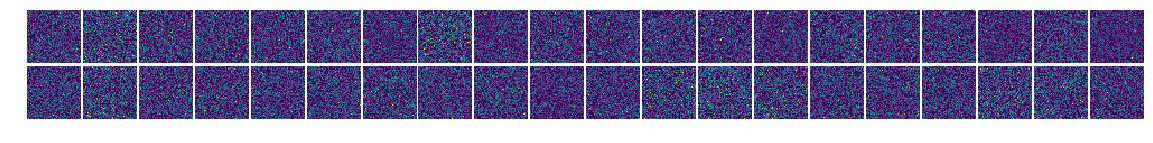

generated 5400 frames of tracks
genarated 5400 track labels
displaying a random sample of 40 frames: 


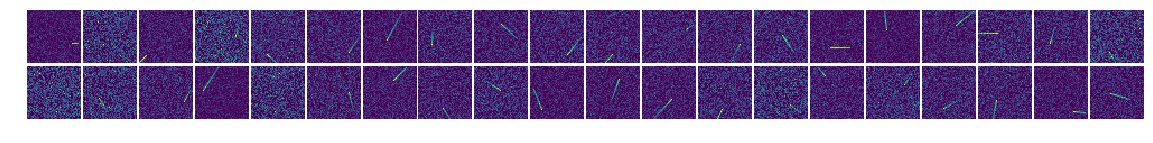

saved generated frames to file in samples/


In [2]:
# set up the TrackModel
track_model = TrackModel()
track_model.mu_c = 10
n_frame = 5400
n_angle = 8

# generate sample background and tracks
with SampleGenerator(track_model) as generator:
    generator.background(n_frame, n_angle)
    generator.tracks(n_frame, n_angle)
    generator.save()

In [3]:
outfilename = 'samples/sample_generator_bg.dat'
with open(outfilename, 'rb') as f:
    data_bg = pickle.load(f)

outfilename = 'samples/sample_generator_track.dat'
with open(outfilename, 'rb') as f:
    data_track = pickle.load(f)

In [4]:
outfilename = 'samples/sample_generator_bg_labels.dat'
with open(outfilename, 'rb') as f:
    labels_bg = pickle.load(f)

outfilename = 'samples/sample_generator_track_labels.dat'
with open(outfilename, 'rb') as f:
    labels_track = pickle.load(f)

Look at the first background image
this image has label:  [0. 0. 0. 0. 0. 0. 0. 0. 1.]


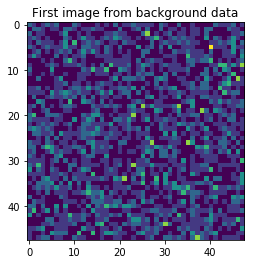

In [5]:
# Look at the first background image
print ("Look at the first background image")

plt.imshow(data_bg[0])
plt.title("First image from background data")

# and its label
print ("this image has label: ", labels_bg[0])

Look at the first track image
this image has label:  [0. 0. 0. 1. 0. 0. 0. 0. 0.]


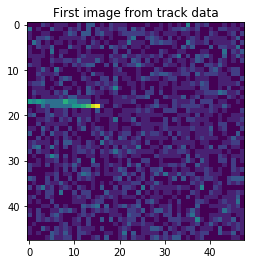

In [6]:
# Look at the first track image
print ("Look at the first track image")

plt.imshow(data_track[0])
plt.title("First image from track data")

# and its label
print ("this image has label: ", labels_track[0])

this image has label:  [0. 0. 0. 0. 0. 0. 1. 0. 0.]


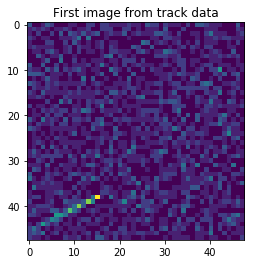

In [7]:
plt.imshow(data_track[1])
plt.title("First image from track data")

# and its label
print ("this image has label: ", labels_track[1])

this image has label:  [0. 0. 0. 0. 0. 0. 0. 1. 0.]


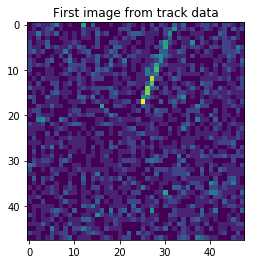

In [8]:
plt.imshow(data_track[2])
plt.title("First image from track data")

# and its label
print ("this image has label: ", labels_track[2])

this image has label:  [0. 0. 0. 0. 0. 1. 0. 0. 0.]


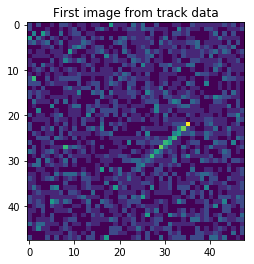

In [9]:
plt.imshow(data_track[3])
plt.title("First image from track data")

# and its label
print ("this image has label: ", labels_track[3])

In [10]:
data = np.concatenate([data_bg, data_track])
data = np.reshape(data, (2*n_frame, 48, 48, 1))

labels = np.concatenate([labels_bg, labels_track])

data, labels = shuffle(data, labels)

validation_ratio = 1/5
index = int(1 - validation_ratio*np.shape(data)[0]/2)-1
# should be index = int(1 - 1/((1/(validation_ratio+1)))*np.shape(data)[0]/2)-1

data_test = data[index:]
labels_test = labels[index:]

data = data[0:index]
labels = labels[0:index]

In [11]:
class MonitorCallback(tflearn.callbacks.Callback):
    def __init__(self):
        self.best_acc = 0
        self.best_loss = 10
        self.best_params = None
        self.best_val_acc_epoch = None
        self.best_loss_epoch = None
    
    def on_epoch_end(self, training_state, snapshot=False):
        if training_state.val_acc > self.best_acc:
            self.best_acc = training_state.val_acc
            self.best_val_acc_epoch = training_state.epoch
            
        if training_state.global_loss < self.best_loss:
            self.best_loss = training_state.global_loss
            self.best_loss_epoch = training_state.epoch
        
    def getBestValAccEpoch(self):
        return self.best_val_acc_epoch
        
    def getBestLossEpoch(self):
        return self.best_loss_epoch
        
    def getBestValAcc(self):
        return self.best_acc 
        
    def getBestLoss(self):
        return self.best_loss
        
        
monitorCallback = MonitorCallback()

In [12]:
start_time = time.time()

# Shuffle the data
#data, labels = shuffle(data, labels)

# Make sure the data is normalized
#img_prep = ImagePreprocessing()
#img_prep.add_featurewise_zero_center()
#img_prep.add_featurewise_stdnorm()

# Create extra synthetic training data by flipping, rotating and blurring the
# images on our data set.
#img_aug = ImageAugmentation()
#img_aug.add_random_flip_leftright()
#img_aug.add_random_rotation(max_angle=25.)
#img_aug.add_random_blur(sigma_max=3.)
#img_aug.add_random_crop((48, 48), 5)


# Define our network architecture:

# Input is a 48x48 image with 1 "color" channel
network = input_data(shape=[None, 48, 48, 1])#,
                     #data_preprocessing=img_prep,
                     #data_augmentation=img_aug)

# Step 1: Convolution
network = conv_2d(network, 16, 3, activation='relu')

# Step 2: Max pooling
network = max_pool_2d(network, 2)

# Step 3: Convolution again
network = conv_2d(network, 64, 3, activation='relu')

network = max_pool_2d(network, 2)

# Step 4: Convolution yet again
network = conv_2d(network, 16, 3, activation='relu')

# Step 5: Max pooling again

network = max_pool_2d(network, 2)

# Step 6: Fully-connected 512 node neural network
network = fully_connected(network, 128, activation='relu')

# Step 7: Dropout - throw away some data randomly during training to prevent over-fitting
network = dropout(network, 0.5)

# Step 8: Fully-connected neural network with two outputs
network = fully_connected(network, n_angle+1, activation='softmax')

# Tell tflearn how we want to train the network
network = regression(network, optimizer='adam',
                     loss='categorical_crossentropy',
                     learning_rate=0.001)

# Wrap the network in a model object
model = tflearn.DNN(network, tensorboard_verbose=0)

# Train it
model.fit(data, labels, n_epoch=120, shuffle=True, validation_set=(data_test, labels_test),
          show_metric=True, batch_size=64,
          #snapshot_epoch=True,
          run_id='track-classifier',
          callbacks=monitorCallback)

# Save model when training is complete to a file
model.save("track-classifier.tfl")

end_time = time.time()

elapsed_time = end_time - start_time

print("Network trained and saved as track-classifier.tfl!")
print("The training took: ", elapsed_time)

Training Step: 151  | total loss: 1.34639 | time: 10.720s
| Adam | epoch: 001 | loss: 1.34639 - acc: 0.5609 -- iter: 9664/9720
Training Step: 152  | total loss: 1.32770 | time: 11.859s
| Adam | epoch: 001 | loss: 1.32770 - acc: 0.5641 | val_loss: 1.28374 - val_acc: 0.5481 -- iter: 9720/9720
--
INFO:tensorflow:C:\Users\Figge\Desktop\kex_2018-master\track-classifier.tfl is not in all_model_checkpoint_paths. Manually adding it.
Network trained and saved as track-classifier.tfl!
The training took:  16.971970558166504


In [16]:
print('Best validation accuracy:', monitorCallback.getBestValAcc())
print('Achieved by the end of epoch', monitorCallback.getBestValAccEpoch())
print('')
print('Best loss:', monitorCallback.getBestLoss())
print('Achieved by the end of epoch', monitorCallback.getBestLossEpoch())

Best validation accuracy: 0.5481481468236005
Achieved by the end of epoch 1

Best loss: 1.327697515487671
Achieved by the end of epoch 1
